In [4]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [6]:
train_data = pd.read_csv("train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
test_data = pd.read_csv("test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [9]:
women = train_data.loc[train_data.Sex =='female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

% of women who survived: 0.7420382165605095


In [10]:
men = train_data.loc[train_data.Sex == 'male']['Survived']
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

% of men who survived: 0.18890814558058924


In [11]:
from sklearn.ensemble import RandomForestClassifier

y = train_data["Survived"]

features = ["Pclass", "Sex", "SibSp", "Parch"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)

predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('Submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


# Titanic - Machine Learning from Disasters

## Kaggle Competition

#### RMS Titanic was a British passenger liner that sank in the North Atlantic Ocean in the early hours of 15 April 1912, after colliding with an iceberg during her maiden voyage from Southampton to New York City. There were an estimated 2,224 passengers and crew aboard, and more than 1,500 died, making it one of the deadliest commercial peacetime maritime disasters in modern history. RMS Titanic was the largest ship afloat at the time she entered service and was the second of three Olympic-class ocean liners operated by the White Star Line.

### In this exercise, we will try to predict whether a passenger on the Titanic would have survived or not.

#### Import the necessary libraries

In [14]:
# Import our libraries
import pandas as pd
import numpy as np

# Import sklearn libraries
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, precision_recall_curve, auc, make_scorer, confusion_matrix, f1_score, fbeta_score

# Import the Naive Bayes, logistic regression, Bagging, RandomForest, AdaBoost, GradientBoost, Decision Trees and SVM Classifier

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#from matplotlib import style
#plt.style.use('bmh')
#plt.style.use('ggplot')
plt.style.use('seaborn-notebook')

from matplotlib.ticker import StrMethodFormatter

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelBinarizer

In [16]:
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [20]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [21]:
train_df.head(8)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


In [22]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
PassengerId,0,0.0
Survived,0,0.0


In [23]:
train_df.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

c:\users\avalon\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\avalon\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\avalon\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use eith

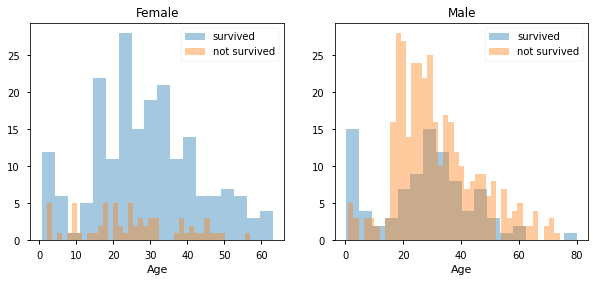

In [24]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
women = train_df[train_df['Sex']=='female']
men = train_df[train_df['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('Male')

c:\users\avalon\appdata\local\programs\python\python39\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


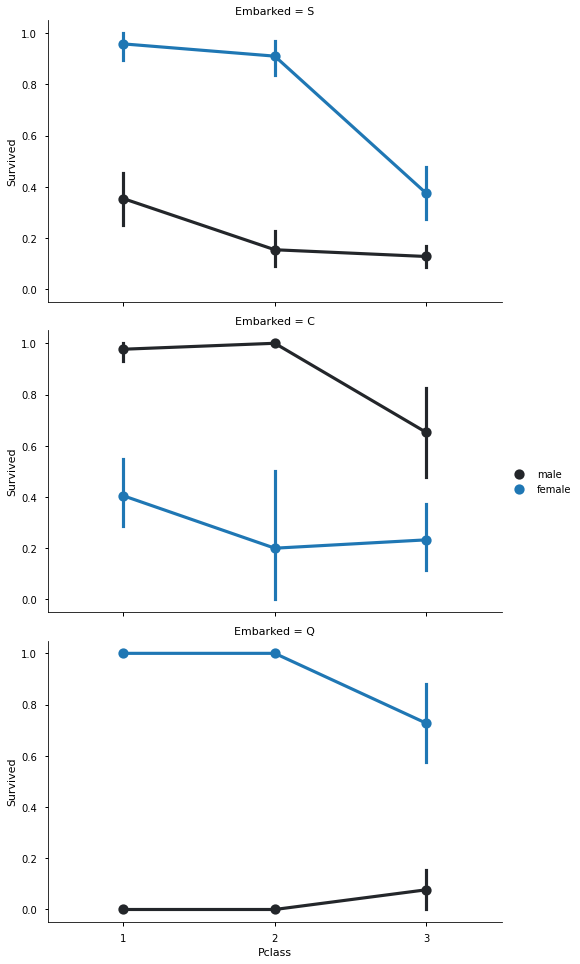

In [25]:
FacetGrid = sns.FacetGrid(train_df, row='Embarked', size=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette=None,  order=None, hue_order=None )
FacetGrid.add_legend()

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

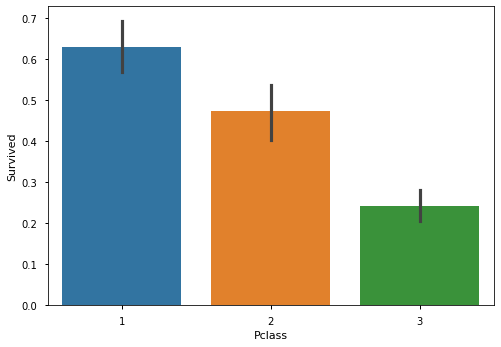

In [26]:
sns.barplot(x='Pclass', y='Survived', data=train_df)


c:\users\avalon\appdata\local\programs\python\python39\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


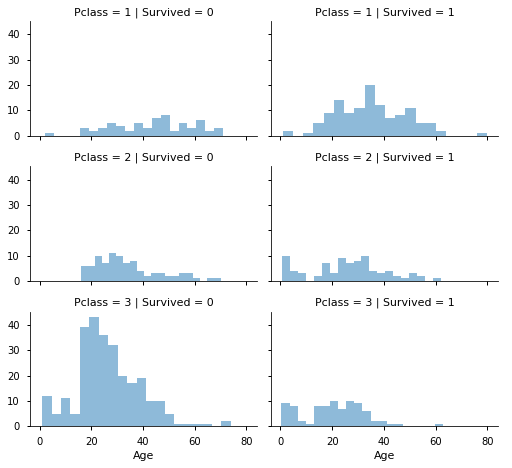

In [27]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

In [28]:
data = [train_df, test_df]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)
train_df['not_alone'].value_counts()

1    537
0    354
Name: not_alone, dtype: int64

c:\users\avalon\appdata\local\programs\python\python39\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\users\avalon\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


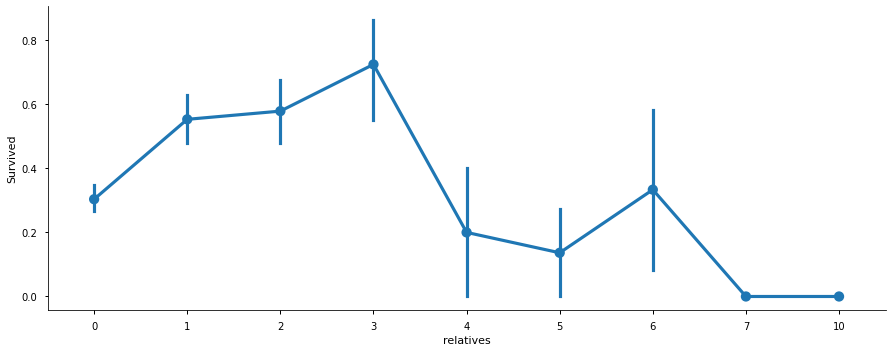

In [31]:
axes = sns.factorplot('relatives','Survived', 
                      data=train_df, aspect = 2.5, )

In [32]:
train_df = train_df.drop(['PassengerId'], axis=1)


In [33]:
import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train_df, test_df]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)
# we can now drop the cabin feature
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)

In [34]:
data = [train_df, test_df]

for dataset in data:
    mean = train_df["Age"].mean()
    std = test_df["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train_df["Age"].astype(int)
train_df["Age"].isnull().sum()

0

In [35]:
train_df['Embarked'].describe()


count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [36]:
common_value = 'S'
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

In [37]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Survived   891 non-null    int64  
 1   Pclass     891 non-null    int64  
 2   Name       891 non-null    object 
 3   Sex        891 non-null    object 
 4   Age        891 non-null    int32  
 5   SibSp      891 non-null    int64  
 6   Parch      891 non-null    int64  
 7   Ticket     891 non-null    object 
 8   Fare       891 non-null    float64
 9   Embarked   891 non-null    object 
 10  relatives  891 non-null    int64  
 11  not_alone  891 non-null    int32  
 12  Deck       891 non-null    int32  
dtypes: float64(1), int32(3), int64(5), object(4)
memory usage: 80.2+ KB


In [38]:
data = [train_df, test_df]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

In [39]:
data = [train_df, test_df]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)
train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

In [40]:
genders = {"male": 0, "female": 1}
data = [train_df, test_df]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

In [41]:
train_df['Ticket'].describe()


count      891
unique     681
top       1601
freq         7
Name: Ticket, dtype: object

In [42]:
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)

In [43]:
ports = {"S": 0, "C": 1, "Q": 2}
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

In [45]:
data = [train_df, test_df]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6

# let's see how it's distributed train_df['Age'].value_counts()

In [46]:
train_df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,not_alone,Deck,Title
0,0,3,0,0,1,0,7,0,1,0,8,1
1,1,1,1,0,1,0,71,1,1,0,3,3
2,1,3,1,0,0,0,7,0,0,1,8,2
3,1,1,1,0,1,0,53,0,1,0,3,3
4,0,3,0,0,0,0,8,0,0,1,8,1
5,0,3,0,0,0,0,8,2,0,1,8,1
6,0,1,0,0,0,0,51,0,0,1,5,1
7,0,3,0,0,3,1,21,0,4,0,8,4
8,1,3,1,0,0,2,11,0,2,0,8,3
9,1,2,1,0,1,0,30,1,1,0,8,3


In [47]:
data = [train_df, test_df]

for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

In [48]:
data = [train_df, test_df]
for dataset in data:
    dataset['Age_Class']= dataset['Age']* dataset['Pclass']

In [49]:
for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['relatives']+1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)
# Let's take a last look at the training set, before we start training the models.
train_df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,not_alone,Deck,Title,Age_Class,Fare_Per_Person
0,0,3,0,0,1,0,0,0,1,0,8,1,0,0
1,1,1,1,0,1,0,3,1,1,0,3,3,0,1
2,1,3,1,0,0,0,0,0,0,1,8,2,0,0
3,1,1,1,0,1,0,3,0,1,0,3,3,0,1
4,0,3,0,0,0,0,1,0,0,1,8,1,0,1
5,0,3,0,0,0,0,1,2,0,1,8,1,0,1
6,0,1,0,0,0,0,3,0,0,1,5,1,0,3
7,0,3,0,0,3,1,2,0,4,0,8,4,0,0
8,1,3,1,0,0,2,1,0,2,0,8,3,0,0
9,1,2,1,0,1,0,2,1,1,0,8,3,0,1


In [50]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()

In [51]:
sgd = linear_model.SGDClassifier(max_iter=5, tol=None)
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)

sgd.score(X_train, Y_train)

acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)

NameError: name 'linear_model' is not defined

In [52]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)

In [53]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)

In [56]:
knn.fit(X_train, Y_train)  Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)

SyntaxError: invalid syntax (Temp/ipykernel_8972/2061364710.py, line 1)

In [57]:
gaussian = GaussianNB() gaussian.fit(X_train, Y_train)  Y_pred = gaussian.predict(X_test)  acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)

SyntaxError: invalid syntax (Temp/ipykernel_8972/2386881411.py, line 1)

In [58]:
perceptron = Perceptron(max_iter=5)
perceptron.fit(X_train, Y_train)

Y_pred = perceptron.predict(X_test)

acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)


NameError: name 'Perceptron' is not defined

In [59]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)

Y_pred = linear_svc.predict(X_test)

acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)

NameError: name 'LinearSVC' is not defined